# Case Study: Bayesian and Gaussian Process Regression for Plume Dispersion Modelling

This notebook presents a detailed case study using **BayeSpace** to model the dispersion of an atmospheric aerosol plume — specifically in the context of **Marine Cloud Brightening (MCB)**. The objective is to infer key physical parameters governing the plume's behaviour using both **Bayesian Regression (BR)** and **Gaussian Process Regression (GPR)**.

We perform this analysis on two types of data:

1. **Simulated plume data**, generated from a log-transformed Gaussian Plume Model (GPM), with known parameters
2. **Real-world plume data**, collected from aerosol dispersion trials

Each dataset is analysed using:
- **Bayesian Regression (BR)**: A parametric approach grounded in physical theory, using MCMC to estimate posterior distributions over model parameters.
- **Gaussian Process Regression (GPR)**: A flexible, non-parametric method that models spatial structure using kernels and provides predictive uncertainty.

This case study demonstrates how BayeSpace enables principled uncertainty quantification and inference in physical environmental models.


### Install Libraries

In [ ]:
from app.regression_toolbox.model import Model, add_model, delete_model
from app.regression_toolbox.likelihood import Likelihood
from app.regression_toolbox.parameter import Parameter
from app.regression_toolbox.sampler import Sampler

from app.visualisation_toolbox.domain import Domain
from app.visualisation_toolbox.visualiser import RegressionVisualiser, GPVisualiser

from app.gaussian_process_toolbox.kernel import Kernel
from app.gaussian_process_toolbox.transformation import Transformation
from app.gaussian_process_toolbox.gaussian_processor import GP

from app.data_processing.sim_data_processor import SimDataProcessor
from app.data_processing.raw_data_processor import RawDataProcessor

import numpy as np
import pandas as pd
import os
import jax

os.chdir('/PhD_project/')
jax.config.update("jax_enable_x64", True)


/build/miniconda3/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Simulating Plume Data using a Log-Transformed Gaussian Plume Model

We begin by generating synthetic plume concentration data based on the log-transformed Gaussian plume model:

$$
C(x, y, z) = \log_{10} \left( \frac{Q}{2\pi I_y I_z x^2} \exp\left(-\frac{y^2}{2 I_y^2 x^2}\right) \left[ \exp\left(-\frac{(z - H)^2}{2 I_z^2 x^2}\right) + \exp\left(-\frac{(z + H)^2}{2 I_z^2 x^2} \right) \right] \right)
$$

We use fixed values for:

- Emission height: $H = 5$
- Lateral spread: $I_y = 0.22$
- Vertical spread: $I_z = 0.2$
- Emission rate: $Q = 3.41 \times 10^{13}$

The simulation is conducted over a spherical domain centered at $(0, 0, 5)$ and cut to include only points below the source (downwind). We apply Gaussian noise with 10% relative error to simulate real-world measurement uncertainty.


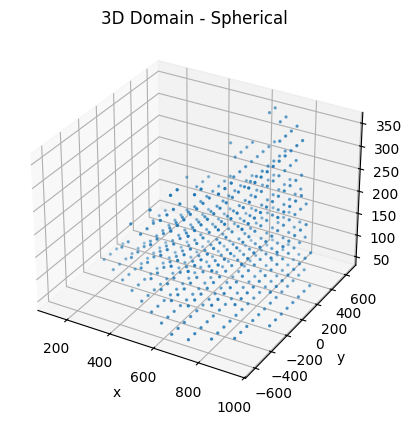

In [2]:
# --- Step 1: Simulate synthetic plume data ---

# Define simulation model with fixed parameters
sim_model = Model('log_gpm_norm')\
    .add_fixed_model_param('H', 5)\
    .add_fixed_model_param('I_y', 0.22)\
    .add_fixed_model_param('I_z', 0.2)\
    .add_fixed_model_param('Q', 3.41e13)

# Build a spherical domain centered at z = 5
sim_domain = Domain(3, 'spherical')
sim_domain.add_domain_param('radius', 1000)\
          .add_domain_param('mass', 10000)\
          .add_domain_param('theta', [-np.pi/8, np.pi/8])\
          .add_domain_param('phi', [-np.pi/4, np.pi/4])\
          .add_domain_param('center', [0, 0, 5])
sim_domain.build_domain()

# Cut the domain to simulate only the region below the source
sim_domain.cut_domain([0, 0, 0], [0, 0, -1])
sim_domain.plot_domain()

# Generate noisy synthetic data with 10% Gaussian percentage noise
sim_data_processor = SimDataProcessor(
    'sandbox',
    sim_model,
    sim_domain,
    noise_dist='gaussian',
    noise_percentage=0.1
)


## Step 2: Bayesian Regression on Simulated Plume Data

We now apply Bayesian Regression to the simulated plume dataset using BayeSpace.

The goal is to infer the parameters controlling the lateral and vertical spread of the plume:

- $I_y \sim \text{Uniform}(0.0001, 1)$  
- $I_z \sim \text{Uniform}(0.0001, 1)$  
- $\epsilon \sim \text{Uniform}(0.0001, 1)$ (observation error)

The source height $H$ and emission rate $Q$ are kept fixed at their true values. The model is evaluated using a **Gaussian percentage error likelihood**, appropriate for data in log-space with multiplicative noise.

After performing inference, we visualise the posterior-predicted plume concentrations by rendering:

- Two **2D cross-sections** through the 3D volume:  
  - A horizontal slice (XZ-plane)  
  - A vertical slice (YZ-plane)  
- The full 3D concentration field using both fixed-angle and interactive views

These cross-sections help interpret the structure of the plume and validate whether the inferred parameters align with the simulated ground truth.


In [3]:
# --- Bayesian Regression on Simulated Plume Data ---

# Define the inference model with known fixed parameters:
# - H: source height (m)
# - Q: emission rate (kg/s)
model = Model('log_gpm_norm')\
    .add_fixed_model_param('H', 5)\
    .add_fixed_model_param('Q', 3.41e13)

# Use a Gaussian likelihood with percentage error, appropriate for log-transformed data
likelihood = Likelihood('gaussian_percentage_error')

# Define inference parameters and their priors
# - I_y: lateral diffusion parameter
# - I_z: vertical diffusion parameter
# - error: percentage error term in the likelihood
I_y = Parameter(name='I_y', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)
I_z = Parameter(name='I_z', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)
error = Parameter(name='error', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)

inference_params = pd.Series({'I_y': I_y, 'I_z': I_z, 'error': error})

# Initialise and run the NUTS sampler with 3 chains of 10,000 samples each
sampler = Sampler(inference_params, model, likelihood, sim_data_processor, n_samples=10000, n_chains=3)
sampler.sample_all()

# --- Domain for Visualisation ---

# Define a high-resolution spherical domain for predictions
vis_domain = Domain(3, 'spherical')
vis_domain.add_domain_param('radius', 1000)\
          .add_domain_param('mass', 100000)\
          .add_domain_param('theta', [-np.pi/8, np.pi/8])\
          .add_domain_param('phi', [-np.pi/4, np.pi/4])\
          .add_domain_param('center', [0, 0, 5])
vis_domain.build_domain()

# Cut the domain to only include the region downwind of the source (negative z)
vis_domain.cut_domain([0, 0, 0], [0, 0, -1])

# Add 2D cross-sections:
# - Horizontal slice through the centre (XZ plane)
# - Vertical slice aligned with plume direction (YZ plane)
vis_domain.apply_cross_section([0, 0, 5], [0, -1, 0], width=100)
vis_domain.apply_cross_section([0, 0, 5], [0, 0, 1], width=100)

# --- Diagnostics and Posterior Visualisation ---

visualiser = RegressionVisualiser(sampler)

# Plot MCMC traceplots and autocorrelation diagnostics
visualiser.get_traceplots()
visualiser.get_autocorrelations()
visualiser.get_summary()  # Tabulated posterior summaries (mean, std, HDI, etc.)

# Reference values for atmospheric stability classes (used as vertical guides)
I_y_ref = {
    'vals': [0.22, 0.16, 0.11, 0.08, 0.06, 0.04],
    'labels': ['A', 'B', 'C', 'D', 'E', 'F']
}
I_z_ref = {
    'vals': [0.2, 0.12, 0.08, 0.06, 0.03, 0.016],
    'labels': ['A', 'B', 'C', 'D', 'E', 'F']
}

# Plot prior distributions with overlaid reference lines
visualiser.plot_prior('I_y', [0.0001, 1], I_y_ref)
visualiser.plot_prior('I_z', [0.0001, 1], I_z_ref)
visualiser.plot_prior('error', [0.0001, 1])

# Plot posterior distributions with stability class markers
visualiser.plot_posterior('I_y', [0.0001, 1], I_y_ref)
visualiser.plot_posterior('I_z', [0.0001, 1], I_z_ref)
visualiser.plot_posterior('error', [0.0001, 1])

# --- Prediction Visualisation ---

# Visualise BR-predicted concentrations:
# - Cross-sections in 2D
# - Full 3D view
# - Layered 3D slices (e.g., isosurfaces by height)
visualiser.show_predictions(vis_domain, 'test_plot', '2D_cross_sections', title='Concentration')
visualiser.show_predictions(vis_domain, 'test_plot', '3D', title='Concentration')
visualiser.show_predictions(vis_domain, 'test_plot', '3D_layers', title='Concentration')


Data loaded from /PhD_project/data/processed_sim_data/sandbox
Plot saved at: /PhD_project/data/processed_sim_data/sandbox
Samples loaded from /PhD_project/results/regression_results/sandbox/instance_1


## Step 3: Gaussian Process Regression on Simulated Data

We now apply **Gaussian Process Regression (GPR)** to the simulated plume dataset. Unlike the physically-constrained Bayesian Regression, GPR is a non-parametric, data-driven approach that makes no assumptions about the underlying functional form of the model.

We define the GP using a **Matérn kernel** over the 3D spatial coordinates $(x, y, z)$, with the following kernel hyperparameters:

- Length scales: $[20, 20, 20]$
- Smoothness parameter: $\nu = 2.5$
- Length scale bounds: $[10, 1000]$

The Matérn kernel used here is the product of three independent Matérn kernels, one for each input dimension (x, y, z). The general Matérn covariance function between two input points $\mathbf{x}, \mathbf{x'}$ is defined as:

$$
k(\mathbf{x}, \mathbf{x'}) = \prod_{d=1}^{3} \frac{1}{\Gamma(\nu)2^{\nu - 1}} \left( \frac{\sqrt{2\nu} \lvert x_d - x_d' \rvert}{\ell_d} \right)^\nu K_\nu \left( \frac{\sqrt{2\nu} \lvert x_d - x_d' \rvert}{\ell_d} \right)
$$

Where:

- $\nu$ is the smoothness parameter (here, $\nu = 2.5$)  
- $\ell_d$ is the length scale in the $d$-th dimension  
- $K_\nu(\cdot)$ is the modified Bessel function of the second kind  
- $\Gamma(\cdot)$ is the Gamma function  

This kernel structure allows anisotropic spatial correlation — i.e., the model can learn different characteristic scales of variation in the x, y, and z directions independently.

The transformation applied to the target variable is the **identity transformation**, preserving the log-scale of the concentration values.

As with the Bayesian model, predictions are made over a high-resolution spherical domain, with two orthogonal 2D cross-sections and a full 3D visualisation to assess spatial structure and uncertainty.


In [4]:
# Define the kernel structure
# - ('matern', 'xyz') means a Matérn kernel applied to 3D inputs: x, y, z
kernel_config = {('matern', 'xyz'): [0, 1, 2]}

# Instantiate the kernel with specified hyperparameters
kernel_obj = Kernel(kernel_config)
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale', [20, 20, 20])           # Characteristic length in x, y, z
kernel_obj.add_kernel_param('matern', 'xyz', 'nu', 2.5)                              # Smoothness parameter
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale_bounds', (10, 1000))     # Bounds for optimisation

# No transformation applied to the data (remain in log-space)
transformation = Transformation('identity')

# Initialise the Gaussian Process model with the simulation data, kernel, and transformation
gp = GP(sim_data_processor, kernel_obj, transformation=transformation)

# Train the GP: compute the optimal hyperparameters and fit to the simulated data
gp_model = gp.train()

# --- Domain for GPR Predictions ---

# Define a high-resolution spherical domain for GP prediction
vis_domain = Domain(3, 'spherical')
vis_domain.add_domain_param('radius', 1000)\
          .add_domain_param('mass', 100000)\
          .add_domain_param('theta', [-np.pi/8, np.pi/8])\
          .add_domain_param('phi', [-np.pi/4, np.pi/4])\
          .add_domain_param('center', [0, 0, 5])
vis_domain.build_domain()

# Cut to include only the downwind region (negative z direction)
vis_domain.cut_domain([0, 0, 0], [0, 0, -1])

# Add 2D cross-sections for visual interpretation
# - Horizontal (XZ plane) and vertical (YZ plane) through source centre
vis_domain.apply_cross_section([0, 0, 5], [0, -1, 0], width=100)
vis_domain.apply_cross_section([0, 0, 5], [0, 0, 1], width=100)

# --- Visualise GPR Predictions ---

# Create a visualiser instance for the GP
visualiser = GPVisualiser(gp)

# Show 2D cross-sections of predicted concentration
visualiser.show_predictions(vis_domain, 'predictions', plot_type='2D_cross_sections')

# Render the full 3D plume prediction (interactive or fixed)
visualiser.show_predictions(vis_domain, 'predictions', plot_type='3D')

# Layered 3D prediction using isosurfaces or sliced volumes
visualiser.show_predictions(vis_domain, 'predictions', plot_type='3D_layers')


Data loaded from /PhD_project/data/processed_sim_data/sandbox
Plot saved at: /PhD_project/data/processed_sim_data/sandbox
Loading existing GP model from /PhD_project/results/gaussian_process_results/sandbox/instance_1/gaussian_process_model.pkl


## Step 4: Processing Real-World Plume Data

In this step, we load and preprocess **real-world plume concentration data** collected during a series of field experiments over the Great Barrier Reef. This dataset includes measured aerosol concentrations from 12 independent experiments involving controlled sea salt releases.

We use BayeSpace’s `RawDataProcessor` to handle:

- Loading and aggregating data from multiple experiments  
- Aligning measurements to a structured 3D grid for inference  
- Applying a log-transformation to the concentration data  
- Extracting vertical and horizontal slices for exploratory diagnostics  

The gridding resolution is set to $[100, 100, 25]$ in the $x, y, z$ directions, balancing spatial fidelity and computational tractability. Output concentrations are stored in log-scale to remain consistent with the simulation-based workflow.

This preprocessed dataset will be used as input for both **Bayesian Regression** and **Gaussian Process Regression** models in the next steps.


In [5]:
# Define parameters for the RawDataProcessor
processor_params = {
    'experiments_list': [
        'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6',
        'Exp7', 'Exp8', 'Exp9', 'Exp10', 'Exp11', 'Exp12'
    ],
    'meta_data_select': 'GBR_data_summary',   # Metadata source for domain info
    'input_header': 'Concentration',          # Input concentration column
    'output_header': 'C',         # Output column name (same here)
    'log_output_data': True,                  # Apply log10 transform to output
    'gridding': [100, 100, 25]                # 3D grid resolution: (x, y, z)
}

# Initialise RawDataProcessor
# - 'GBR_data': path or label for raw data
# - 'GBR_data_gridded_100_100_25': output identifier for saved results
# - 'GBR_processor': unique name for the processor
# - processor_params: controls I/O and grid handling
raw_data_processor = RawDataProcessor(
    'GBR_data',
    'GBR_data_gridded_100_100_25',
    'GBR_processor',
    processor_params=processor_params,
)


## Step 5: Bayesian Regression on Real-World Plume Data

We now apply Bayesian Regression to the real-world data collected from the MCB field trials over the Great Barrier Reef.

As in the simulation case, we use a log-transformed Gaussian plume model to describe the expected concentration at each point in space. However, the observed data now come from actual measurements, and thus introduce real environmental noise and experimental uncertainty.

The model assumes the following parameters are known or fixed:

- Source height: $ H = 5 $
- Emission rate: $ Q = 3.41 \times 10^{13} $

We aim to infer:

- Lateral diffusion: $ I_y \sim \text{Uniform}(0.0001, 1) $
- Vertical diffusion: $ I_z \sim \text{Uniform}(0.0001, 1) $
- Percentage observation error: $ \epsilon \sim \text{Uniform}(0.0001, 1) $

The likelihood is again defined using **Gaussian percentage error**, which is well suited for log-transformed data and multiplicative uncertainty.

After sampling the posterior distributions, we generate predictions and visualise them over 2D cross-sections and in 3D. This enables direct interpretation of how well the inferred parameters capture the observed spatial structure of the aerosol plume.


In [6]:
# --- Step 5: Bayesian Inference on Real-World GBR Data ---

# Define the model: log-transformed Gaussian plume model with fixed H and Q
model = Model('log_gpm_norm')\
    .add_fixed_model_param('H', 5)\
    .add_fixed_model_param('Q', 3.41e13)

# Use the same likelihood function as before (percentage error in log-space)
likelihood = Likelihood('gaussian_percentage_error')

# Define inference parameters:
# - I_y and I_z (diffusion spreads) are unknown
# - error accounts for observational noise and model mismatch
I_y = Parameter(name='I_y', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)
I_z = Parameter(name='I_z', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)
error = Parameter(name='error', prior_select='uniform').add_prior_param('low', 0.0001).add_prior_param('high', 1)

# Combine parameters into a Series for the sampler
inference_params = pd.Series({'I_y': I_y, 'I_z': I_z, 'error': error})

# Initialise and run the sampler on real data with 3 chains of 10,000 samples
sampler = Sampler(
    inference_params,
    model,
    likelihood,
    raw_data_processor,  # <-- real-world data processor
    n_samples=10000,
    n_chains=3
)
sampler.sample_all()

# --- Domain for Visualisation ---

# Use the same spherical domain as before for prediction and visualisation
vis_domain = Domain(3, 'spherical')
vis_domain.add_domain_param('radius', 1000)\
          .add_domain_param('mass', 100000)\
          .add_domain_param('theta', [-np.pi/8, np.pi/8])\
          .add_domain_param('phi', [-np.pi/4, np.pi/4])\
          .add_domain_param('center', [0, 0, 5])
vis_domain.build_domain()
vis_domain.cut_domain([0, 0, 0], [0, 0, -1])

# Add horizontal and vertical cross-sections through the domain
vis_domain.apply_cross_section([0, 0, 5], [0, -1, 0], width=100)
vis_domain.apply_cross_section([0, 0, 5], [0, 0, 1], width=100)

# --- Posterior Diagnostics and Visualisation ---

visualiser = RegressionVisualiser(sampler)

# Traceplots and diagnostics
visualiser.get_traceplots()
visualiser.get_autocorrelations()
visualiser.get_summary()

# Optional: atmospheric stability reference values
I_y_ref = {
    'vals': [0.22, 0.16, 0.11, 0.08, 0.06, 0.04],
    'labels': ['A', 'B', 'C', 'D', 'E', 'F']
}
I_z_ref = {
    'vals': [0.2, 0.12, 0.08, 0.06, 0.03, 0.016],
    'labels': ['A', 'B', 'C', 'D', 'E', 'F']
}

# Prior and posterior plots
visualiser.plot_prior('I_y', [0.0001, 1], I_y_ref)
visualiser.plot_prior('I_z', [0.0001, 1], I_z_ref)
visualiser.plot_prior('error', [0.0001, 1])

visualiser.plot_posterior('I_y', [0.0001, 1], I_y_ref)
visualiser.plot_posterior('I_z', [0.0001, 1], I_z_ref)
visualiser.plot_posterior('error', [0.0001, 1])

# Show BR-based predictions on real data
visualiser.show_predictions(vis_domain, 'realdata_predictions', '2D_cross_sections', title='Concentration')
visualiser.show_predictions(vis_domain, 'realdata_predictions', '3D', title='Concentration')
visualiser.show_predictions(vis_domain, 'realdata_predictions', '3D_layers', title='Concentration')


Data loaded from data/processed_raw_data/GBR_data_gridded_100_100_25
Samples loaded from /PhD_project/results/regression_results/GBR_data_gridded_100_100_25/instance_1


## Step 6: Gaussian Process Regression on Real-World Plume Data

In this final step, we apply Gaussian Process Regression (GPR) to the real-world concentration data from the GBR field experiments. GPR offers a flexible, non-parametric alternative to the physically-constrained Gaussian plume model used in Bayesian Regression.

We again use a Matérn kernel over the 3D input space $(x, y, z)$, configured with the same structure as in the simulation:

- Independent length scales in each dimension  
- Smoothness parameter $\nu = 2.5$  
- Length scale bounds set between 10 and 1000 meters

The model is trained using log-transformed aerosol concentrations, and the transformation applied to the output is identity — preserving the original log-space representation of the data.

After training, we use the GP to predict plume concentration over a high-resolution domain. Predictions are rendered via cross-sections and 3D volume plots to compare against the results of Bayesian inference. This step helps us assess the relative flexibility and generalisation ability of GPR in handling noisy environmental datasets.


In [ ]:
# Define the GP kernel: Matérn over 3D space with independent length scales
kernel_config = {('matern', 'xyz'): [0, 1, 2]}  # Apply over x, y, z dimensions

# Instantiate the kernel with hyperparameters
kernel_obj = Kernel(kernel_config)
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale', [20, 20, 20])           # Initial guess
kernel_obj.add_kernel_param('matern', 'xyz', 'nu', 2.5)                              # Smoothness
kernel_obj.add_kernel_param('matern', 'xyz', 'length_scale_bounds', (10, 1000))     # Bounds for optimisation

# Identity transformation — data remains in log-space
transformation = Transformation('identity')

# Initialise the GP model using the real-world data processor
gp = GP(raw_data_processor, kernel_obj, transformation=transformation)

# Train the GP — fit hyperparameters and compute posterior
gp_model = gp.train()

# --- Domain for Predictions ---

# Use same high-res spherical domain for prediction as in previous steps
vis_domain = Domain(3, 'spherical')
vis_domain.add_domain_param('radius', 1000)\
          .add_domain_param('mass', 100000)\
          .add_domain_param('theta', [-np.pi/8, np.pi/8])\
          .add_domain_param('phi', [-np.pi/4, np.pi/4])\
          .add_domain_param('center', [0, 0, 5])
vis_domain.build_domain()
vis_domain.cut_domain([0, 0, 0], [0, 0, -1])

# Apply cross-sections:
# - Horizontal cut through XZ plane
# - Vertical cut through YZ plane
vis_domain.apply_cross_section([0, 0, 5], [0, -1, 0], width=100)
vis_domain.apply_cross_section([0, 0, 5], [0, 0, 1], width=100)

# --- Visualise GP Predictions on Real Data ---

# Create a visualiser instance for the GP
visualiser = GPVisualiser(gp)

# Show GP predictions across different views
visualiser.show_predictions(vis_domain, 'predictions', plot_type='2D_cross_sections', title='Concentration')
visualiser.show_predictions(vis_domain, 'predictions', plot_type='3D', title='Concentration')
visualiser.show_predictions(vis_domain, 'predictions', plot_type='3D_layers', title='Concentration')


Data loaded from data/processed_raw_data/GBR_data_gridded_100_100_25
Loading existing GP model from /PhD_project/results/gaussian_process_results/GBR_data_gridded_100_100_25/instance_1/gaussian_process_model.pkl
Animation saved as /PhD_project/results/gaussian_process_results/GBR_data_gridded_100_100_25/instance_1/realdata_gp/layered_predictions.gif
